In [1]:
import glob
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import numpy as np

In [2]:
q = "Data/final_tmdb_data_*.csv.gz"
chunked_files = sorted(glob.glob(q))

## Loading all files as df and appending to a list
df_list = []
for file in chunked_files:
    temp_df = pd.read_csv(file, index_col=0)
    df_list.append(temp_df)
    
## Concatenating the list of dfs into 1 combined
df_combined = pd.concat(df_list)
df_combined

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
imdb_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,Two rural teens sing and dance their way throu...,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.500,22.0,NaN
tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,Earth is in a state of constant war and two co...,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.450,10.0,NaN
tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,"After falling prey to underworld, four friends...",...,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,4.000,1.0,NaN
tt0118694,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,843.0,cn,花樣年華,Two neighbors become intimate after discoverin...,...,14204632.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.101,2369.0,PG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt9906644,0.0,/htoReVItKtolso5VJqFqJDBaOwm.jpg,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,635903.0,ml,മനോഹരം,Manoharan is a poster artist struggling to fin...,...,0.0,122.0,"[{'english_name': 'Malayalam', 'iso_639_1': 'm...",Released,NaN,Manoharam,0.0,6.042,12.0,NaN
tt9913660,0.0,/z6YpkQiWLnRKl5yQD9dSiPDFWN.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,711261.0,en,No Apology,When a group of women struggle to deal with th...,...,0.0,102.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,No Apology,0.0,8.000,1.0,NaN
tt9913872,0.0,/a0kySBmMZ77AqmNA3pDu45GsbCp.jpg,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",NaN,800030.0,es,De la piel del Diablo,NaN,...,0.0,0.0,[],Released,NaN,De la piel del Diablo,0.0,8.200,3.0,NaN


In [3]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41202 entries, 0 to tt9915872
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  41190 non-null  float64
 1   backdrop_path          27396 non-null  object 
 2   belongs_to_collection  2817 non-null   object 
 3   budget                 41190 non-null  float64
 4   genres                 41190 non-null  object 
 5   homepage               10293 non-null  object 
 6   id                     41190 non-null  float64
 7   original_language      41190 non-null  object 
 8   original_title         41190 non-null  object 
 9   overview               40348 non-null  object 
 10  popularity             41190 non-null  float64
 11  poster_path            38312 non-null  object 
 12  production_companies   41190 non-null  object 
 13  production_countries   41190 non-null  object 
 14  release_date           40543 non-null  object 
 15  rev

In [4]:
df_combined.dropna(inplace=True)

# Hypothesis Test: The stakeholder's first question is: does the MPAA rating of a movie (G/PG/PG-13/R) affect how much revenue the movie generates?

State your Null Hypothesis and Alternative Hypothesis

* Null Hypothesis 
   - The MPAA rating makes no difference to revenue
* Alternative Hypothesis 
   - The revenue is effected by the MPAA rating

In [5]:
df_combined['certification'].value_counts()

certification
PG-13    179
R        151
PG       114
NR        32
G         25
NC-17      1
Name: count, dtype: int64

In [6]:
df_combined = df_combined[df_combined.certification != 'NC-17']

In [7]:
groups = {}
## Loop through all unique categories
for i in df_combined['certification'].unique():
    ## Get series for group and rename
    data = df_combined.loc[df_combined['certification']==i,'revenue'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['PG-13', 'R', 'G', 'PG', 'NR'])

In [8]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
PG-13,179.0,1.533020e-14,63.617903
R,151.0,6.181034e-18,79.250092
G,25.0,2.892422e-05,20.901663
PG,114.0,8.753674e-08,32.502415
NR,32.0,4.373154e-11,47.705903


In [9]:
# with the * operator 
stats.levene(*groups.values())

LeveneResult(statistic=21.09336197347511, pvalue=4.454702564209656e-16)

## Performed hypothesis test got a p-value (NOT assumption test)

In [10]:
result = stats.f_oneway( *groups.values())
result

F_onewayResult(statistic=22.861766994108493, pvalue=2.3602992838233285e-17)

In [11]:
values = df_combined['revenue']
labels = df_combined['certification']

## perform tukey's multiple comparison test and display the summary
tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
G,NR,-159249457.6012,0.4482,-419006337.1413,100507421.9388,False
G,PG,151575331.2414,0.3022,-63336138.5069,366486800.9898,False
G,PG-13,291476195.7415,0.0013,83701245.0028,499251146.4801,True
G,R,-28298675.5253,0.9961,-238421137.1739,181823786.1233,False
NR,PG,310824788.8427,0.0001,116143757.9951,505505819.6902,True
NR,PG-13,450725653.3427,0.0,263952544.7406,637498761.9449,True
NR,R,130950782.076,0.3223,-58430349.0638,320331913.2157,False
PG,PG-13,139900864.5,0.0096,23292556.6575,256509172.3426,True
PG,R,-179874006.7667,0.0005,-300615533.1475,-59132480.3859,True
PG-13,R,-319774871.2668,0.0,-427301642.4346,-212248100.0989,True


Due to the P-value being lesser than the significance level of alpha "0.05", we can safely say that we will have to reject the Null hypothesis, the Null hypothesis being that The MPAA rating makes no difference to revenue. Below you will find An appropriate visualization to compare the groups means is included.

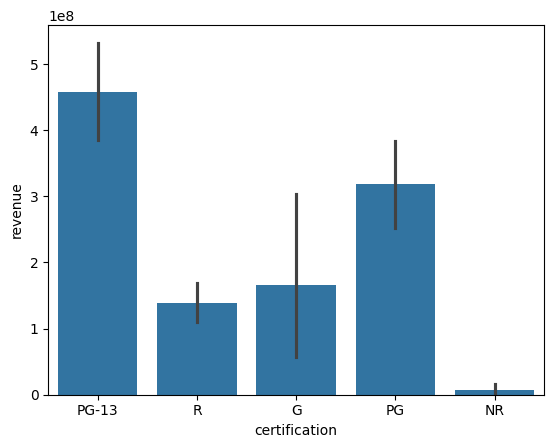

In [12]:
sns.barplot(data=df_combined, x='certification',y='revenue');

# ///////////////////////////////////////////////////////////////////////////////////////////////////

# Hypothesis Test: Do movies that contain english have a higher revenue?

State your Null Hypothesis and Alternative Hypothesis

* Null Hypothesis 
   - The Movie language will not effect revenue
* Alternative Hypothesis 
   - The revenue is effected by the langauge of the movie

## Separate the data into two groups

In [13]:
# Filtering out movies that are english and not
english_df = df_combined.loc[df_combined['spoken_languages'].str.contains('English')].copy()
non_english_df = df_combined.loc[~df_combined['spoken_languages'].str.contains('English')].copy()
english_rev_df = english_df['revenue']
non_english_rev_df = non_english_df['revenue']

### Removed outliers from any non-normal distributions.

In [14]:
# check outliers from english revenue
zscores= stats.zscore(english_rev_df)
outliers = abs(zscores)>3
np.sum(outliers)

7

In [15]:
# remove outliers from english revenue
english_rev_df = english_rev_df[(np.abs(stats.zscore(english_rev_df)) < 3)]

In [16]:
# check outliers from non english revenue
zscores= stats.zscore(non_english_rev_df)
outliers = abs(zscores)>3
np.sum(outliers)

1

In [17]:
# remove outliers from non english revenue
non_english_rev_df = non_english_rev_df[(np.abs(stats.zscore(non_english_rev_df)) < 3)]

### Tested assumption of normality 

In [18]:
# test the english group for normality
result_english_rev_df = stats.normaltest(english_rev_df)
result_english_rev_df

NormaltestResult(statistic=93.02044480975704, pvalue=6.322182924677828e-21)

In [19]:
# test the non-english group for normality
result_non_english_rev_df = stats.normaltest(non_english_rev_df)
result_non_english_rev_df

NormaltestResult(statistic=18.470353586684155, pvalue=9.7546946494094e-05)

### Tested assumption of equal variance 

In [20]:
# Test for equal variance
print(np.var(english_rev_df), np.var(non_english_rev_df))
result = stats.levene(english_rev_df, non_english_rev_df)
result

1.1529263332847683e+17 681700141283518.9


LeveneResult(statistic=38.905103553585704, pvalue=9.608620901009383e-10)

## Performed hypothesis test got a p-value (NOT assumption test)

In [21]:
# Independent t-test with equal_var set to False
statistic , pvalue = stats.ttest_ind(english_rev_df, non_english_rev_df, equal_var = False)
print("statistic :" , statistic)
print("pvalue :" , pvalue)
pvalue<.05

statistic : 16.67201189929595
pvalue : 1.6787745760571644e-49


True

Due to the P-value being lesser than the significance level of alpha "0.05", we can safely say that we will have to reject the Null hypothesis, the Null hypothesis being that The Movie language will not effect revenue. Below you will find An appropriate visualization to compare the groups means is included.

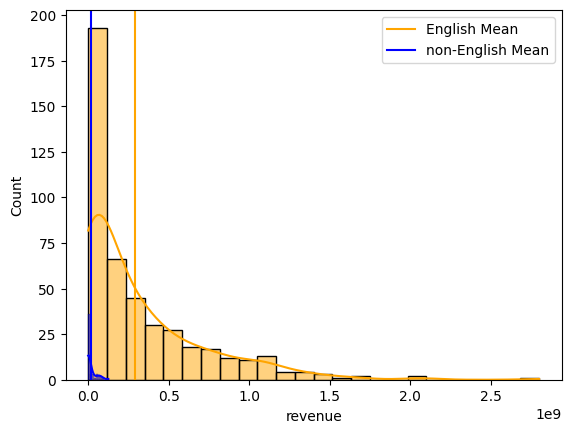

In [22]:
ax = sns.histplot(data=english_df,x='revenue',kde =True, color='orange')
ax = sns.histplot(data=non_english_df,x='revenue',kde =True, color='blue')
ax.axvline(english_rev_df.mean(), color='orange',label='English Mean')
ax.axvline(non_english_rev_df.mean(), color='blue', label='non-English Mean')
ax.legend();

# ///////////////////////////////////////////////////////////////////////////////////////////////////

# Hypothesis Test: Do movies that are over 2.5 hours long earn more revenue than movies that are 1.5 hours long (or less)?

State your Null Hypothesis and Alternative Hypothesis

* Null Hypothesis 
   - The Movie length will not affect revenue
* Alternative Hypothesis 
   - The revenue is effected by the length of the movie

## Separate the data into two groups (“has discount” and “no discount”) 

In [23]:
# Filtering out movies that are longer than 2,5 hours and shorter than 1,5 hours
longer_df = df_combined.loc[df_combined['runtime']>150].copy()
shorter_df = df_combined.loc[df_combined['runtime']<=90].copy()
longer_rev_df = longer_df['revenue']
shorter_rev_df = shorter_df['revenue']

### Removed outliers from any non-normal distributions.

In [24]:
# check outliers from >2,5 revenue
zscores= stats.zscore(longer_rev_df)
outliers = abs(zscores)>3
np.sum(outliers)

0

In [25]:
# check outliers from <1,5 revenue
zscores= stats.zscore(shorter_rev_df)
outliers = abs(zscores)>3
np.sum(outliers)

3

In [26]:
# remove outliers from <1,5 revenue
shorter_rev_df = shorter_rev_df[(np.abs(stats.zscore(shorter_rev_df)) < 3)]

### Tested assumption of normality 

In [27]:
# test the longer group for normality
result_longer_rev_df = stats.normaltest(longer_rev_df)
result_longer_rev_df

C:\Users\CHBAM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


NormaltestResult(statistic=14.223359894060177, pvalue=0.0008155238038734292)

In [28]:
# test the shorter group for normality
result_shorter_rev_df = stats.normaltest(shorter_rev_df)
result_shorter_rev_df

NormaltestResult(statistic=73.67137377895112, pvalue=1.0056907294607807e-16)

### Tested assumption of equal variance 

In [29]:
# Test for equal variance
print(np.var(longer_rev_df), np.var(shorter_rev_df))
result = stats.levene(longer_rev_df, shorter_rev_df)
result

4.0821284147011245e+17 1.1823841032990454e+16


LeveneResult(statistic=37.25810151296544, pvalue=2.0269060918296847e-08)

In [30]:
# Independent t-test with equal_var set to False
statistic , pvalue = stats.ttest_ind(longer_rev_df, shorter_rev_df, equal_var = False)
print("statistic :" , statistic)
print("pvalue :" , pvalue)
pvalue<.05

statistic : 4.766908379783856
pvalue : 0.0003593715675889508


True

Due to the P-value being lesser than the significance level of alpha "0.05", we can safely say that we will have to reject the Null hypothesis, the Null hypothesis being that The Movie length will not affect revenue. Below you will find An appropriate visualization to compare the groups means is included.

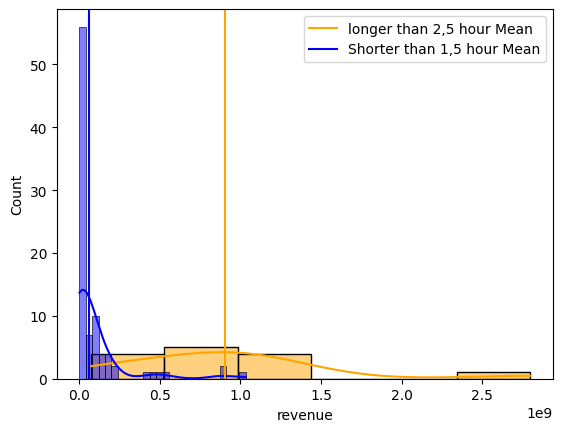

In [31]:
ax = sns.histplot(data=longer_df,x='revenue',kde =True, color='orange')
ax = sns.histplot(data=shorter_df,x='revenue',kde =True, color='blue')
ax.axvline(longer_rev_df.mean(), color='orange',label='longer than 2,5 hour Mean')
ax.axvline(shorter_rev_df.mean(), color='blue', label='Shorter than 1,5 hour Mean')
ax.legend();